## Figure 3E, 3F

In [1]:
import mat73
import h5py
import hdf5storage as st
# from pymatreader import read_mat
import pickle
import os

import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
import matplotlib.patches as patches

from scipy.stats import wilcoxon, norm, kruskal, tukey_hsd, mannwhitneyu, sem
from scipy.optimize import curve_fit
from scipy.io import loadmat
from scipy.linalg import null_space
from scipy.spatial.distance import cdist
import seaborn as sns
from copy import deepcopy
from statsmodels.stats.multitest import multipletests
import math
from itertools import combinations, product

from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA

from umap import UMAP

# from libsvm import svmutil

# import torch
# import torch.nn as nn
# import torch.optim as optim

# from pycaret.classification import *

c:\Users\USER\anaconda3\envs\allensdk_cl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# loading variables

# openscope
with open('SVM_prerequisite_variables.pickle', 'rb') as f:
    SVM_prerequisite_variables = pickle.load(f)
    
    list_rate_w1 = SVM_prerequisite_variables['list_rate_w1'].copy()
    list_stm_w1 = SVM_prerequisite_variables['list_stm_w1'].copy()
    list_neu_loc = SVM_prerequisite_variables['list_neu_loc'].copy()
    list_wfdur = SVM_prerequisite_variables['list_wfdur'].copy()
    list_slopes_an_loglog = SVM_prerequisite_variables['list_slopes_an_loglog'].copy()
    list_slopes_an_loglog_12 = SVM_prerequisite_variables['list_slopes_an_loglog_12'].copy()

# ABO Neuropixels
with open('resp_matrix_ep_RS_all_32sess_allensdk.pickle', 'rb') as f:
    resp_matrix_ep_RS_all = pickle.load(f)

    list_rate_RS = resp_matrix_ep_RS_all['list_rate_RS'].copy()
    list_rate_RS_dr = resp_matrix_ep_RS_all['list_rate_RS_dr'].copy()
    list_rate_all = resp_matrix_ep_RS_all['list_rate_all'].copy()
    list_rate_all_dr = resp_matrix_ep_RS_all['list_rate_all_dr'].copy()
    list_slopes_RS_an_loglog = resp_matrix_ep_RS_all['list_slopes_RS_an_loglog'].copy()
    list_slopes_all_an_loglog = resp_matrix_ep_RS_all['list_slopes_all_an_loglog'].copy()

    sess_inds_qual_all = resp_matrix_ep_RS_all['sess_inds_qual_all'].copy()

In [3]:
def compute_mean_var_trial(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        trial_mean = np.mean(trial_rate, axis=1)
        trial_var = np.var(trial_rate, axis=1, ddof=1)

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = pd.concat([trial_mean] * label_cnt_dict[trial_type], axis=1)
        list_trial_var[trial_ind] = pd.concat([trial_var] * label_cnt_dict[trial_type], axis=1)

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [4]:
def compute_mean_var_trial_collapse(label_cnt_dict, rate_sorted):    
    list_trial_mean = [[0]] * len(label_cnt_dict)
    list_trial_var = [[0]] * len(label_cnt_dict)

    for trial_ind, trial_type in enumerate(label_cnt_dict):
        
        trial_rate = np.array(rate_sorted.loc[:, trial_type])                
        trial_mean = np.mean(trial_rate, axis=1, dtype=np.longdouble)
        trial_var = np.var(trial_rate, axis=1, ddof=1, dtype=np.longdouble)

        trial_mean = pd.DataFrame(trial_mean, columns=[trial_type], index=rate_sorted.index)
        trial_var = pd.DataFrame(trial_var, columns=[trial_type], index=rate_sorted.index)
        list_trial_mean[trial_ind] = trial_mean.copy()
        list_trial_var[trial_ind] = trial_var.copy()

    rate_sorted_mean = pd.concat(list_trial_mean, axis=1)
    rate_sorted_var = pd.concat(list_trial_var, axis=1)

    return rate_sorted_mean, rate_sorted_var

In [5]:
# Function to compute cosine similarity
def cos_sim(x, y):
    # x and y are 1D vectors

    # dot_xy = np.dot(x, y)
    # norm_x, norm_y = np.linalg.norm(x.astype(np.float32)), np.linalg.norm(y.astype(np.float32))

    # cos_sim = dot_xy / (norm_x * norm_y)

    return np.dot(x, y) / (np.linalg.norm(x.astype(np.float32)) * np.linalg.norm(y.astype(np.float32)))

In [6]:
def annotate_lineplot_significance(significant_values, axes, ax_ind, line_height_ratio, color):

    if len(significant_values) > 0:

        # Initialize start and end points of lines
        start = None
        lines = []
        dots = []

        # Loop through sorted significant_values to group them into lines or dots
        for i in range(len(significant_values) - 1):
            if start is None:
                start = significant_values[i]

            # Check if the next value is part of the same line
            if significant_values[i + 1] - significant_values[i] > 0.1 + 1e-9:  # Threshold for a gap; add pseudo-value to avoid floating point issue
                if start == significant_values[i]:
                    dots.append(start)  # Isolated point
                else:
                    lines.append((start, significant_values[i]))  # Line segment
                start = None

        # Check the last value
        if start is None:
            dots.append(significant_values[-1])
        else:
            lines.append((start, significant_values[-1]))

        # Plot lines and dots
        for line in lines:
            if isinstance(axes, np.ndarray):
                axes[ax_ind].hlines(axes[ax_ind].get_ylim()[0]+(axes[ax_ind].get_ylim()[1]-axes[ax_ind].get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)  # Draw a line
            elif isinstance(axes, plt.Axes):
                axes.hlines(axes.get_ylim()[0]+(axes.get_ylim()[1]-axes.get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)
            else:
                plt.hlines(plt.gca().get_ylim()[0]+(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*line_height_ratio, \
                    xmin=line[0], xmax=line[1], colors=color)
                
        for dot in dots:
            if isinstance(axes, np.ndarray):
                axes[ax_ind].hlines(axes[ax_ind].get_ylim()[0]+(axes[ax_ind].get_ylim()[1]-axes[ax_ind].get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)  # Draw a very short line
            elif isinstance(axes, plt.Axes):
                axes.hlines(axes.get_ylim()[0]+(axes.get_ylim()[1]-axes.get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)
            else:
                plt.hlines(plt.gca().get_ylim()[0]+(plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*line_height_ratio, \
                    xmin=dot-0.01, xmax=dot+0.01, colors=color)

## Figure 3E left

session index: 6


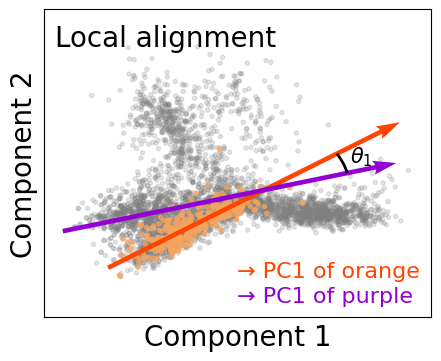

In [ ]:
# PC1 alignment example plot (as-is) 
    
num_trials = 400 

# Iterate over all sessions

for sess_ind, (rate_all, stm, neu_loc, wfdur) in enumerate(zip(list_rate_w1, list_stm_w1, list_neu_loc, list_wfdur)):
    
    if sess_ind == 6:
    
        print(f'session index: {sess_ind}')

        # rate_all transposition
        rate_all = rate_all.T.copy()

        # Extract V1 neurons
        ser_neu_loc = pd.Series(neu_loc)
        list_visp = [ser_neu_loc.str.contains('VISp'), ~ser_neu_loc.str.contains('VISpm')]
        rate = rate_all[[all(bools) for bools in zip(*list_visp)]].copy()
        # print(rate.shape[0])
        # list_visp_rs = [ser_neu_loc.str.contains('VISp'), ~ser_neu_loc.str.contains('VISpm'), (wfdur >= 0.4)]
        # rate = rate_all[[all(bools) for bools in zip(*list_visp_rs)]].copy()
        # print(np.sum([all(bools) for bools in zip(*list_visp_rs)]))

        # Multiply by delta t to convert to spike counts
        rate = rate * 0.4
        
        # Create a counting dictionary for each stimulus
        all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
        stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))
        dict_trial_type = {0: 'Blank', 1: 'X', 2:'Tc1', 3: 'Ic1', 4: 'Lc1', 5:'Tc2', 6: 'Lc2', 7: 'Ic2', \
            8: 'Ire1', 9: 'Ire2', 10: 'Tre1', 11: 'Tre2', 12: 'Xre1', 13: 'Xre2', 14: 'BR_in', 15: 'BL_in', \
                16: 'TL_in', 17: 'TR_in', 18: 'BR_out', 19: 'BL_out', 20: 'TL_out', 21: 'TR_out'}
        
        # Create label array for all stimuli
        label = []
        for i in stm:
            for trial_type_num in dict_trial_type:
                if i == trial_type_num:
                    label.append(dict_trial_type[trial_type_num])
        label = np.array(label)

        # convert to dataframe
        rate = pd.DataFrame(rate, columns=label)

        # sort trials based on stimuli
        rate_sorted = rate.sort_index(axis=1)
        label_sorted = np.array(sorted(label))

        # Create a counting dictionary for each stimulus 
        all_label_unique, all_label_counts = np.unique(label, return_counts=True) 
        label_cnt_dict = dict(zip(all_label_unique, all_label_counts))

        # Extract stimuli having 400 repeats (trials)
        rate_sorted = rate_sorted.loc[:, all_label_unique[all_label_counts == 400]].copy()
        all_label_unique, all_label_counts = np.unique(rate_sorted.columns, return_counts=True) 
        label_cnt_dict = dict(zip(all_label_unique, all_label_counts))

        # Compute mean & variance for each stimulus
        rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(label_cnt_dict, rate_sorted)
        rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(label_cnt_dict, rate_sorted)

        # isomap
        n_components = 2 # target number of dimensions
        # n_components = rate_sorted.shape[0] # target number of dimensions
        n_neighbors = 5 # number of neighbors

        isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
        
        rate_isomap = pd.DataFrame(isomap.fit_transform(rate_sorted.T).T, columns=rate_sorted.columns) # isomap without centroids 
        rate_plus_mean_isomap, _ = compute_mean_var_trial_collapse(label_cnt_dict, rate_isomap) 

        bool_Tre2 = rate_isomap.columns == 'Tre2'
        bool_Lc1 = rate_isomap.columns == 'Lc1'
        bool_rest = ~bool_Lc1

        # pca
        pca = PCA(n_components=n_components)

        rate_Tre2_pca = pca.fit_transform(rate_isomap.loc[:, 'Tre2'].T).T
        pc1_Tre2 = pca.components_[0].copy()
        rate_Lc1_pca = pca.fit_transform(rate_isomap.loc[:, 'Lc1'].T).T
        pc1_Lc1 = pca.components_[0].copy()
        rate_rest_pca = pca.fit_transform(rate_isomap.loc[:, bool_rest].T).T
        pc1_rest = pca.components_[0].copy()

        # color list & label list
        list_colors = np.repeat(np.array(['gray'], dtype=object), rate_isomap.shape[1])
        # list_colors[bool_Tre2] = 'mediumpurple'
        list_colors[bool_Lc1] = 'sandybrown'
        
        rgba_colors = np.array([mcolors.to_rgba(color, alpha=0.2) if color == 'gray' else mcolors.to_rgba(color, alpha=0.7) for color in list_colors])
        
        # as-is scatterplot
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))

        # trials
        ax.scatter(rate_isomap.iloc[0, bool_rest], rate_isomap.iloc[1, bool_rest], marker='.', color=rgba_colors[bool_rest], zorder=1) 
        ax.scatter(rate_isomap.iloc[0, bool_Tre2], rate_isomap.iloc[1, bool_Tre2], marker='.', color=rgba_colors[bool_Tre2], zorder=2)
        ax.scatter(rate_isomap.iloc[0, bool_Lc1], rate_isomap.iloc[1, bool_Lc1], marker='.', color=rgba_colors[bool_Lc1], zorder=2)

        # vectors
        pc1_Lc1_ori = rate_plus_mean_isomap.loc[:, 'Lc1'].copy() # a point that Lc1 PC1 crosses
        ax.quiver(pc1_Lc1_ori[0]-70*pc1_Lc1[0], pc1_Lc1_ori[1]-70*pc1_Lc1[1], 1200*pc1_Lc1[0], 1200*pc1_Lc1[1],
                  color='orangered', scale=5, angles="xy", scale_units="xy", width=0.012, zorder=3) # Lc1 PC1
        pc1_Tre2_ori = rate_plus_mean_isomap.loc[:, 'Tre2'].copy() # a point that Tre2 PC1 crosses
        ax.quiver(pc1_Tre2_ori[0]-70*pc1_Tre2[0], pc1_Tre2_ori[1]-70*pc1_Tre2[1], 1200*pc1_Tre2[0], 1200*pc1_Tre2[1],
                  color='darkviolet', scale=5, angles="xy", scale_units="xy", width=0.012, zorder=3) # Tre2 PC1
        
        # Annotate angle

        # # local alignment

        # noise-noise alignment
        slope_1 = pc1_Tre2[1]/pc1_Tre2[0]
        slope_2 = pc1_Lc1[1]/pc1_Lc1[0]        
        theta1 = np.degrees(np.arctan(slope_1)) 
        theta2 = np.degrees(np.arctan(slope_2))
        intsec_point_x = (slope_2*pc1_Lc1_ori[0] - pc1_Lc1_ori[1] - slope_1*pc1_Tre2_ori[0] + pc1_Tre2_ori[1]) / (slope_2 - slope_1) # x-coordinate of crossing point between PC1's of Lc1 and Tre2
        intsec_point_y = slope_1 * (intsec_point_x - pc1_Tre2_ori[0]) + pc1_Tre2_ori[1]
        angle_arc = patches.Arc((intsec_point_x, intsec_point_y),
                                width=120, height=120, angle=0, theta1=theta1, theta2=theta2, color='black', lw=2, zorder=3)
        ax.add_patch(angle_arc) # draw arc

        x_width = 60
        y_width = 24
        ax.text(intsec_point_x + x_width, intsec_point_y + y_width, '$\\theta_1$', fontsize=15, zorder=4) # annotate theta

        ax.annotate(f'Local alignment', xy=(0.03, 0.88), xycoords='axes fraction', fontsize=20, color='k')
        ax.annotate(f'→ PC1 of orange', xy=(0.5, 0.13), xycoords='axes fraction', fontsize=16, color='orangered')
        ax.annotate(f'→ PC1 of purple', xy=(0.5, 0.05), xycoords='axes fraction', fontsize=16, color='darkviolet')

        # ax.set_title('as-is', fontsize=20)
        ax.tick_params('both', labelsize=18)

        ax.set_xlim([-120, 150])
        ax.set_ylim([-100, 170])
        # ax.set_aspect('equal')
        ax.set_xticks([]) # remove ticks and label
        ax.set_yticks([])
        ax.set_xlabel('Component 1', fontsize=20)
        ax.set_ylabel('Component 2', fontsize=20)

        plt.show()

## Figure 3F left

session index: 6


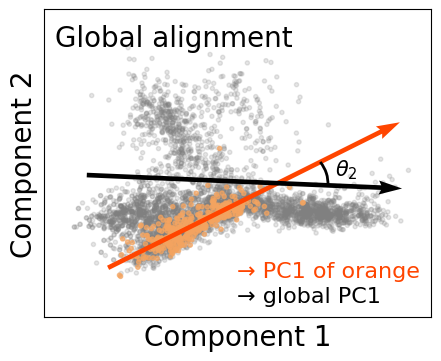

In [ ]:
# PC1 alignment example plot (as-is) 
    
num_trials = 400 

# Iterate over all sessions

for sess_ind, (rate_all, stm, neu_loc, wfdur) in enumerate(zip(list_rate_w1, list_stm_w1, list_neu_loc, list_wfdur)):
    
    if sess_ind == 6:
    
        print(f'session index: {sess_ind}')

        # rate_all transposition
        rate_all = rate_all.T.copy()

        # Extract V1 neurons
        ser_neu_loc = pd.Series(neu_loc)
        list_visp = [ser_neu_loc.str.contains('VISp'), ~ser_neu_loc.str.contains('VISpm')]
        rate = rate_all[[all(bools) for bools in zip(*list_visp)]].copy()
        # print(rate.shape[0])
        # list_visp_rs = [ser_neu_loc.str.contains('VISp'), ~ser_neu_loc.str.contains('VISpm'), (wfdur >= 0.4)]
        # rate = rate_all[[all(bools) for bools in zip(*list_visp_rs)]].copy()
        # print(np.sum([all(bools) for bools in zip(*list_visp_rs)]))

        # Multiply by delta t to convert to spike counts
        rate = rate * 0.4
        
        # Create a counting dictionary for each stimulus
        all_stm_unique, all_stm_counts = np.unique(stm, return_counts=True) 
        stm_cnt_dict = dict(zip(all_stm_unique, all_stm_counts))
        dict_trial_type = {0: 'Blank', 1: 'X', 2:'Tc1', 3: 'Ic1', 4: 'Lc1', 5:'Tc2', 6: 'Lc2', 7: 'Ic2', \
            8: 'Ire1', 9: 'Ire2', 10: 'Tre1', 11: 'Tre2', 12: 'Xre1', 13: 'Xre2', 14: 'BR_in', 15: 'BL_in', \
                16: 'TL_in', 17: 'TR_in', 18: 'BR_out', 19: 'BL_out', 20: 'TL_out', 21: 'TR_out'}
        
        # Create label array for all stimuli
        label = []
        for i in stm:
            for trial_type_num in dict_trial_type:
                if i == trial_type_num:
                    label.append(dict_trial_type[trial_type_num])
        label = np.array(label)

        # convert to dataframe
        rate = pd.DataFrame(rate, columns=label)

        # sort trials based on stimuli
        rate_sorted = rate.sort_index(axis=1)
        label_sorted = np.array(sorted(label))

        # Create a counting dictionary for each stimulus 
        all_label_unique, all_label_counts = np.unique(label, return_counts=True) 
        label_cnt_dict = dict(zip(all_label_unique, all_label_counts))

        # Extract stimuli having 400 repeats (trials)
        rate_sorted = rate_sorted.loc[:, all_label_unique[all_label_counts == 400]].copy()
        all_label_unique, all_label_counts = np.unique(rate_sorted.columns, return_counts=True) 
        label_cnt_dict = dict(zip(all_label_unique, all_label_counts))

        # Compute mean & variance for each stimulus
        rate_sorted_mean, rate_sorted_var = compute_mean_var_trial(label_cnt_dict, rate_sorted)
        rate_sorted_mean_coll, rate_sorted_var_coll = compute_mean_var_trial_collapse(label_cnt_dict, rate_sorted)

        # isomap
        n_components = 2 # target number of dimensions
        # n_components = rate_sorted.shape[0] # target number of dimensions
        n_neighbors = 5 # number of neighbors

        isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)

        # rate_plus_mean = pd.concat([rate_sorted, rate_sorted_mean_coll.loc[:, ['Tre2', 'Lc1']]], axis=1) # concatenate centroids
        # rate_plus_mean_isomap = isomap.fit_transform(rate_plus_mean.T).T # isomap including centroids
        
        rate_isomap = pd.DataFrame(isomap.fit_transform(rate_sorted.T).T, columns=rate_sorted.columns) # isomap without centroids 
        rate_plus_mean_isomap, _ = compute_mean_var_trial_collapse(label_cnt_dict, rate_isomap) 

        bool_Tre2 = rate_isomap.columns == 'Tre2'
        bool_Lc1 = rate_isomap.columns == 'Lc1'
        bool_rest = ~bool_Lc1

        # pca
        pca = PCA(n_components=n_components)

        rate_Tre2_pca = pca.fit_transform(rate_isomap.loc[:, 'Tre2'].T).T
        pc1_Tre2 = pca.components_[0].copy()
        rate_Lc1_pca = pca.fit_transform(rate_isomap.loc[:, 'Lc1'].T).T
        pc1_Lc1 = pca.components_[0].copy()
        rate_rest_pca = pca.fit_transform(rate_isomap.loc[:, bool_rest].T).T
        pc1_rest = pca.components_[0].copy()

        # color list & label list
        list_colors = np.repeat(np.array(['gray'], dtype=object), rate_isomap.shape[1])
        # list_colors[bool_Tre2] = 'mediumpurple'
        list_colors[bool_Lc1] = 'sandybrown'
        
        rgba_colors = np.array([mcolors.to_rgba(color, alpha=0.2) if color == 'gray' else mcolors.to_rgba(color, alpha=0.7) for color in list_colors])
        
        # as-is scatterplot
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))

        # trials
        ax.scatter(rate_isomap.iloc[0, bool_rest], rate_isomap.iloc[1, bool_rest], marker='.', color=rgba_colors[bool_rest], zorder=1) 
        ax.scatter(rate_isomap.iloc[0, bool_Tre2], rate_isomap.iloc[1, bool_Tre2], marker='.', color=rgba_colors[bool_Tre2], zorder=2)
        ax.scatter(rate_isomap.iloc[0, bool_Lc1], rate_isomap.iloc[1, bool_Lc1], marker='.', color=rgba_colors[bool_Lc1], zorder=2)

        # vectors
        pc1_Lc1_ori = rate_plus_mean_isomap.loc[:, 'Lc1'].copy() # a point that Lc1 PC1 crosses
        ax.quiver(pc1_Lc1_ori[0]-70*pc1_Lc1[0], pc1_Lc1_ori[1]-70*pc1_Lc1[1], 1200*pc1_Lc1[0], 1200*pc1_Lc1[1],
                  color='orangered', scale=5, angles="xy", scale_units="xy", width=0.012, zorder=3) # Lc1 PC1
        pc1_rest_ori = (0, 20) # a point that global PC1 crosses
        ax.quiver(pc1_rest_ori[0]-90*pc1_rest[0], pc1_rest_ori[1]-90*pc1_rest[1], 1100*pc1_rest[0], 1100*pc1_rest[1],
                  color='k', scale=5, angles="xy", scale_units="xy", width=0.012, zorder=3) # global PC1
        
        # Annotate angle

        # global alignment
        slope_1 = pc1_rest[1]/pc1_rest[0]
        slope_2 = pc1_Lc1[1]/pc1_Lc1[0]        
        theta1 = np.degrees(np.arctan(slope_1)) 
        theta2 = np.degrees(np.arctan(slope_2))
        intsec_point_x = (slope_2*pc1_Lc1_ori[0] - pc1_Lc1_ori[1] + pc1_rest_ori[1]) / (slope_2 - slope_1) # x-coordinate of crossing point between PC1's of Lc1 and global manifold
        intsec_point_y = intsec_point_x*slope_1 + 20
        angle_arc = patches.Arc((intsec_point_x, intsec_point_y),
                                width=70, height=70, angle=0, theta1=theta1, theta2=theta2, color='black', lw=2, zorder=3)
        ax.add_patch(angle_arc) # draw arc

        x_width = 40
        y_width = 6.5
        ax.text(intsec_point_x + x_width, intsec_point_y + y_width, '$\\theta_2$', fontsize=15) # annotate theta

        ax.annotate(f'Global alignment', xy=(0.03, 0.88), xycoords='axes fraction', fontsize=20, color='k')
        ax.annotate(f'→ PC1 of orange', xy=(0.5, 0.13), xycoords='axes fraction', fontsize=16, color='orangered')
        ax.annotate(f'→ global PC1', xy=(0.5, 0.05), xycoords='axes fraction', fontsize=16, color='k')

        # ax.set_title('as-is', fontsize=20)
        ax.tick_params('both', labelsize=18)

        ax.set_xlim([-120, 150])
        ax.set_ylim([-100, 170])
        # ax.set_aspect('equal')
        ax.set_xticks([]) # remove ticks and label
        ax.set_yticks([])
        ax.set_xlabel('Component 1', fontsize=20)
        ax.set_ylabel('Component 2', fontsize=20)

        plt.show()

In [ ]:
# # Collect alignment for each slope

# # adjacency_type = 'cos_sim'
# adjacency_type = 'geodesic'

# list_target_slopes = np.linspace(-1, 2, 31, endpoint=True)
# list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

# num_sess = 32
# num_trial_types = 119

# list_cos_sim_pc1_adj_RRneuron3 = np.zeros((len(list_target_slopes), num_sess, num_trial_types))
# list_cos_sim_pc1_ori_RRneuron3 = np.zeros((len(list_target_slopes), num_sess, num_trial_types))
# list_cos_sim_pc1_global_RRneuron3 = np.zeros((len(list_target_slopes), num_sess, num_trial_types))
# for slope_ind, target_slope in enumerate(list_target_slopes):
#     file_name = 'align_pc1_ABO_' + adjacency_type + str(slope_ind) + '.pickle'
    
#     with open(file_name, 'rb') as f:
#         align_analysis = pickle.load(f)
#         if slope_ind == 0:
#             list_cos_sim_pc1_adj2 = align_analysis['list_cos_sim_pc1_adj2'].copy()
#             list_cos_sim_pc1_ori2 = align_analysis['list_cos_sim_pc1_ori2'].copy()   
#             list_cos_sim_pc1_global2 = align_analysis['list_cos_sim_pc1_global2'].copy()
#         list_cos_sim_pc1_adj_RRneuron3[slope_ind] = align_analysis['list_cos_sim_pc1_adj_RRneuron2'].copy()
#         list_cos_sim_pc1_ori_RRneuron3[slope_ind] = align_analysis['list_cos_sim_pc1_ori_RRneuron2'].copy()
#         list_cos_sim_pc1_global_RRneuron3[slope_ind] = align_analysis['list_cos_sim_pc1_global_RRneuron2'].copy()

# save_file_name = 'align_pc1_localpc1_ABO_all_' + adjacency_type + '.pickle'
# # save_file_name = os.path.join('..', 'data', save_file_name)
# with open(save_file_name, 'wb') as f:
#     pickle.dump({'tree_variables': ['list_cos_sim_pc1_adj2', 'list_cos_sim_pc1_ori2', 'list_cos_sim_pc1_global2',
#                                     'list_cos_sim_pc1_adj_RRneuron3', 'list_cos_sim_pc1_ori_RRneuron3', 'list_cos_sim_pc1_global_RRneuron3'],
#                                     'list_cos_sim_pc1_adj2': list_cos_sim_pc1_adj2, 'list_cos_sim_pc1_ori2': list_cos_sim_pc1_ori2, 'list_cos_sim_pc1_global2': list_cos_sim_pc1_global2,
#                                     'list_cos_sim_pc1_adj_RRneuron3': list_cos_sim_pc1_adj_RRneuron3, 'list_cos_sim_pc1_ori_RRneuron3': list_cos_sim_pc1_ori_RRneuron3, 'list_cos_sim_pc1_global_RRneuron3': list_cos_sim_pc1_global_RRneuron3}, f)

## Figure 3E right, 3F right

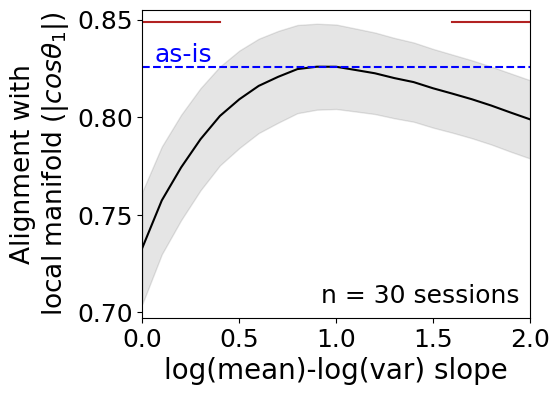

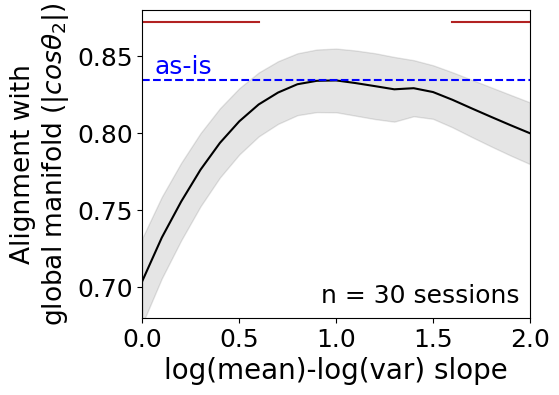

In [ ]:
adjacency_type = 'geodesic'
save_file_name = 'align_pc1_localpc1_ABO_all_' + adjacency_type + '.pickle' 
# save_file_name = os.path.join('..', 'data', save_file_name)
with open(save_file_name, 'rb') as f:
    align_pc1_ABO_all = pickle.load(f)

    list_cos_sim_pc1_adj2 = align_pc1_ABO_all['list_cos_sim_pc1_adj2'].copy()
    list_cos_sim_pc1_ori2 = align_pc1_ABO_all['list_cos_sim_pc1_ori2'].copy()
    list_cos_sim_pc1_global2 = align_pc1_ABO_all['list_cos_sim_pc1_global2'].copy()
    
    list_cos_sim_pc1_adj_RRneuron3 = align_pc1_ABO_all['list_cos_sim_pc1_adj_RRneuron3'].copy()
    list_cos_sim_pc1_ori_RRneuron3 = align_pc1_ABO_all['list_cos_sim_pc1_ori_RRneuron3'].copy()
    list_cos_sim_pc1_global_RRneuron3 = align_pc1_ABO_all['list_cos_sim_pc1_global_RRneuron3'].copy()

list_target_slopes = np.linspace(0, 2, 21, endpoint=True)

num_sess = 32

# Exclude low quality sessions (0, 6)
list_cos_sim_pc1_adj2 = np.concatenate([list_cos_sim_pc1_adj2[1:6], list_cos_sim_pc1_adj2[7:]], axis=0)
list_cos_sim_pc1_ori2 = np.concatenate([list_cos_sim_pc1_ori2[1:6], list_cos_sim_pc1_ori2[7:]], axis=0)
list_cos_sim_pc1_global2 = np.concatenate([list_cos_sim_pc1_global2[1:6], list_cos_sim_pc1_global2[7:]], axis=0)

list_cos_sim_pc1_adj_RRneuron3 = np.concatenate([list_cos_sim_pc1_adj_RRneuron3[:, 1:6], list_cos_sim_pc1_adj_RRneuron3[:, 7:]], axis=1)
list_cos_sim_pc1_ori_RRneuron3 = np.concatenate([list_cos_sim_pc1_ori_RRneuron3[:, 1:6], list_cos_sim_pc1_ori_RRneuron3[:, 7:]], axis=1)
list_cos_sim_pc1_global_RRneuron3 = np.concatenate([list_cos_sim_pc1_global_RRneuron3[:, 1:6], list_cos_sim_pc1_global_RRneuron3[:, 7:]], axis=1)

num_sess = list_cos_sim_pc1_adj2.shape[0]

# Wilcoxon signed-rank test

# 1. local alignment
list_pvals_cos_sim_pc1_adj_mean = np.zeros(len(list_target_slopes))
for slope_ind, target_slope in enumerate(list_target_slopes):
    list_pvals_cos_sim_pc1_adj_mean[slope_ind] = list(wilcoxon(np.mean(list_cos_sim_pc1_adj2, axis=1), \
                        np.mean(list_cos_sim_pc1_adj_RRneuron3[slope_ind], axis=1)))[1]

# 2. global alignment
list_pvals_cos_sim_pc1_global_mean = np.zeros(len(list_target_slopes))
for slope_ind, target_slope in enumerate(list_target_slopes):
    list_pvals_cos_sim_pc1_global_mean[slope_ind] = list(wilcoxon(np.mean(list_cos_sim_pc1_global2, axis=1), \
                        np.mean(list_cos_sim_pc1_global_RRneuron3[slope_ind], axis=1)))[1]

list_sig_slopes_pc1_adj = list_target_slopes[list_pvals_cos_sim_pc1_adj_mean < 0.05].copy()
list_sig_slopes_pc1_global = list_target_slopes[list_pvals_cos_sim_pc1_global_mean < 0.05].copy()

# line plot

# local alignment
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
axes = np.array(axes).flatten()

list_means_cos_sim_pc1_adj_RRneuron = np.mean(list_cos_sim_pc1_adj_RRneuron3, axis=(1, 2))
list_errs_cos_sim_pc1_adj_RRneuron = sem(np.mean(list_cos_sim_pc1_adj_RRneuron3, axis=2), axis=1)

axes[0].plot(list_target_slopes, list_means_cos_sim_pc1_adj_RRneuron, color='k')
axes[0].fill_between(list_target_slopes, list_means_cos_sim_pc1_adj_RRneuron-list_errs_cos_sim_pc1_adj_RRneuron, \
                     list_means_cos_sim_pc1_adj_RRneuron+list_errs_cos_sim_pc1_adj_RRneuron, color='k', alpha=0.1)

# significance
# axes[0].set_ylim(0.22, 0.3)
# annotate_lineplot_significance(list_sig_slopes_pc1_adj, axes=axes, ax_ind=0, line_height_ratio=0.96, color='firebrick')
axes[0].axhline(0.96*np.ptp(axes[0].get_ylim())+axes[0].get_ylim()[0], xmin=0, xmax=0.4/2, color='firebrick')
axes[0].axhline(0.96*np.ptp(axes[0].get_ylim())+axes[0].get_ylim()[0], xmin=1.6/2, xmax=2/2, color='firebrick')
axes[0].axhline(np.mean(list_cos_sim_pc1_adj2), c='blue', linestyle='--') # as-is average

axes[0].set_xlabel('log(mean)-log(var) slope', fontsize=20)
axes[0].set_ylabel('Alignment with\nlocal manifold ($|cos\\theta_1|$)', fontsize=19)
axes[0].tick_params('both', labelsize=18)
# axes[0].set_yticks(np.arange(0.2, 0.35, 0.05))

# axes[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1), prop={'size': 12})
height = (np.mean(list_cos_sim_pc1_adj2)-axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1]-axes[0].get_ylim()[0])
axes[0].annotate('as-is', xy=(0.03, height+0.02), xycoords='axes fraction', fontsize=18, color='blue')
axes[0].annotate(f'n = {num_sess} sessions', xy=(0.46, 0.05), xycoords='axes fraction', fontsize=18, color='k')

axes[0].set_xlim(0, 2)

# global alignment
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
axes = np.array(axes).flatten()

list_means_cos_sim_pc1_global_RRneuron = np.mean(list_cos_sim_pc1_global_RRneuron3, axis=(1, 2))
list_errs_cos_sim_pc1_global_RRneuron = sem(np.mean(list_cos_sim_pc1_global_RRneuron3, axis=2), axis=1)

axes[0].plot(list_target_slopes, list_means_cos_sim_pc1_global_RRneuron, color='k')
axes[0].fill_between(list_target_slopes, list_means_cos_sim_pc1_global_RRneuron-list_errs_cos_sim_pc1_global_RRneuron, \
                     list_means_cos_sim_pc1_global_RRneuron+list_errs_cos_sim_pc1_global_RRneuron, color='k', alpha=0.1)

# significance
axes[0].set_ylim(0.68, 0.88)
# annotate_lineplot_significance(list_sig_slopes_pc1_global, axes=axes, ax_ind=0, line_height_ratio=0.96, color='firebrick')
axes[0].axhline(0.96*np.ptp(axes[0].get_ylim())+axes[0].get_ylim()[0], xmin=0, xmax=0.6/2, color='firebrick')
axes[0].axhline(0.96*np.ptp(axes[0].get_ylim())+axes[0].get_ylim()[0], xmin=1.6/2, xmax=2/2, color='firebrick')
axes[0].axhline(np.mean(list_cos_sim_pc1_global2), c='blue', linestyle='--') # as-is average

axes[0].set_xlabel('log(mean)-log(var) slope', fontsize=20)
axes[0].set_ylabel('Alignment with\nglobal manifold ($|cos\\theta_2|$)', fontsize=19)
axes[0].tick_params('both', labelsize=18)
# axes[0].set_yticks(np.arange(0, 1.05, 0.2))

# axes[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1), prop={'size': 12})
height = (np.mean(list_cos_sim_pc1_global2)-axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1]-axes[0].get_ylim()[0])
axes[0].annotate('as-is', xy=(0.03, height+0.02), xycoords='axes fraction', fontsize=18, color='blue')
axes[0].annotate(f'n = {num_sess} sessions', xy=(0.46, 0.05), xycoords='axes fraction', fontsize=18, color='k')

axes[0].set_xlim(0, 2)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()